In [1]:
import json
import jsonlines
import statistics
from transformers import AutoTokenizer

class DateSorted:
    """
    sort & deduplicate data by the infernece result
    """
    def __init__(self, threshold = 0.05, workers = 128, num_perm = 2048, inference_path = None, folder_path = None,file_path = None,tokenizer_path = None, output_path = None):
        self.threshold = float(threshold)
        self.workers = int(workers)
        self.num_perm = int(num_perm)
        self.tokenizer_path = tokenizer_path
        self.inference_path = inference_path
        self.folder_path = folder_path
        self.file_path = file_path
        self.output_path = output_path
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path) if tokenizer_path is not None else None

    def get_mean(self, data_list):
        '''
        get the mean of a list
        '''
        return sum(data_list) / len(data_list)

    def standardize01(self, data_list):
        '''
        Standardizes the given list of data using 0-1 normalization
        '''
        min_value = min(data_list)
        max_value = max(data_list)
        
        # If all data points are the same (max_value == min_value), standardize them to 0.5.
        if max_value == min_value:
            return [0.5] * len(data_list)
        
        return [(x - min_value) / (max_value - min_value) for x in data_list]

    def standardize(self, data_list):
        '''
        Standardizes the given list of data
        '''
        mean_value = statistics.mean(data_list)
        std_value = statistics.stdev(data_list)
        return [(x - mean_value) / std_value for x in data_list]
        

    def sorted_file(self):
        '''
        sort the data by the proportion and variance
        '''
        score = []
        proportions = []
        variances = []
        with open(self.inference_path, 'r') as f:
            for line in f:
                try:
                    obj = json.loads(line)
                    data_id = obj['data_id']
                    proportion_mean = self.get_mean(obj['first_layer_proportion_score'])
                    variance_mean = self.get_mean(obj['variance'])
                    proportions.append(proportion_mean)
                    variances.append(variance_mean)
                    score.append({"data_id": data_id, "proportion_mean": proportion_mean, "variance_mean": variance_mean})
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON: {e}")
                    print("last char: ", line[-1])
                    print("first char: ", line[0])
                    continue
        
        # Calculate the standard deviation of variances and proportion

        standardized_proportions = self.standardize01(proportions)
        standardized_variances = self.standardize01(variances)

        # Use proportion_mean / variance_std as the new score
        for idx, item in enumerate(score):
            standardized_proportion = standardized_proportions[idx]
            standardized_variance = standardized_variances[idx]
            item['token_distance_score'] = standardized_proportion - 0.5*standardized_variance
            # item['token_distance_score'] = standardized_proportion - standardized_variance
        
        # Sort based on the new score
        score_sorted = sorted(score, key=lambda item: item['token_distance_score'], reverse=True)
        
        # Choose the top half of the sorted data
        length = len(score_sorted)
        half = length // 2    # Modify Filter Ratio
        tds = [item['data_id'] for item in score_sorted[:half]]
        
        return tds, score_sorted

    def write_to_file(self):
        cnt = 0
        fls, _ = self.sorted_file()
        # fls = self.sorted_file()
        with jsonlines.open(self.file_path, 'r') as reader, jsonlines.open(self.output_path, 'w') as first_layer_writer:
            for data in reader:
                data_id = data['data_id']
                if data_id in fls:
                    first_layer_writer.write(data)
                else:
                    cnt+=1 
        print(cnt)
        print("All data has been written to the output file.")

/fsx/jason/LongAttn/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
INFERENCE_PATH="/fsx/jason/LongAttn/output.jsonl"
FILE_PATH="/fsx/jason/LongAttn/sample_output.jsonl"
OUTPUT_PATH="tmp.tmp"

ds = DateSorted(inference_path=INFERENCE_PATH,
        file_path=FILE_PATH,
        output_path=OUTPUT_PATH
    )

In [5]:
tds, scores = ds.sorted_file()

In [16]:
unique_scores = list({d['data_id']: d for d in scores}.values())

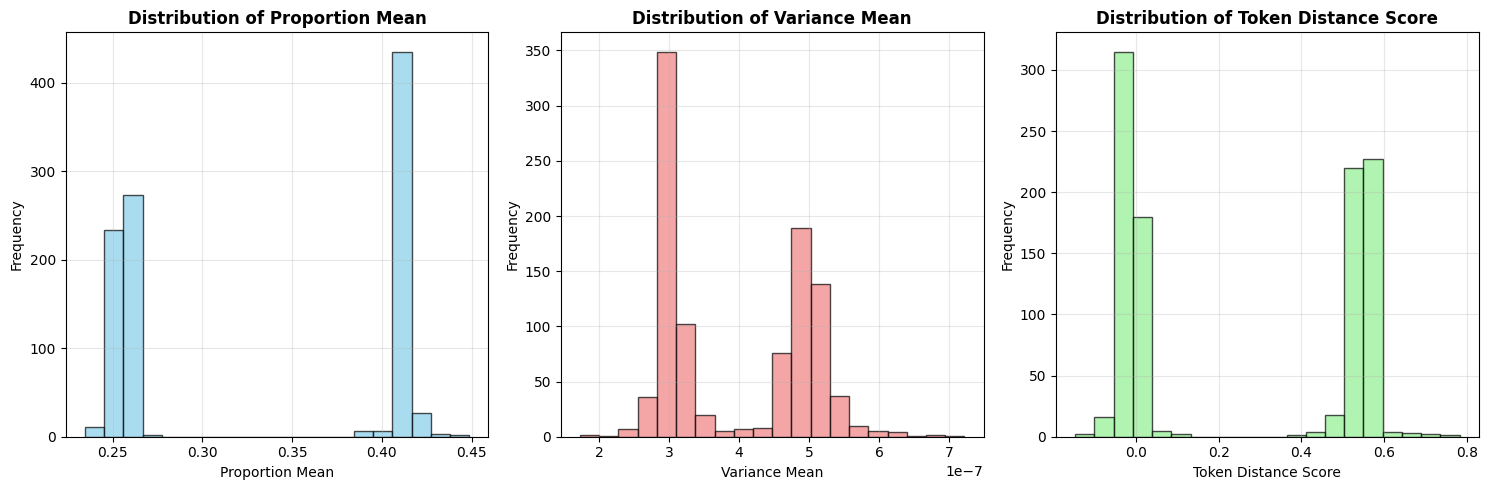

Basic Statistics:
Proportion Mean - Min: 0.2346, Max: 0.4486, Mean: 0.3311
Variance Mean - Min: 1.73e-07, Max: 7.22e-07, Mean: 3.96e-07
Token Distance Score - Min: -0.1471, Max: 0.7827, Mean: 0.2559


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the three score types from your scores array
proportion_means = [item['proportion_mean'] for item in unique_scores]
variance_means = [item['variance_mean'] for item in unique_scores]
token_distance_scores = [item['token_distance_score'] for item in unique_scores]

# Create figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Proportion Mean
ax1.hist(proportion_means, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Proportion Mean', fontsize=12, fontweight='bold')
ax1.set_xlabel('Proportion Mean')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Plot 2: Variance Mean
ax2.hist(variance_means, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_title('Distribution of Variance Mean', fontsize=12, fontweight='bold')
ax2.set_xlabel('Variance Mean')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)
# Format x-axis to show scientific notation clearly
ax2.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 3: Token Distance Score
ax3.hist(token_distance_scores, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
ax3.set_title('Distribution of Token Distance Score', fontsize=12, fontweight='bold')
ax3.set_xlabel('Token Distance Score')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Print some basic statistics
print("Basic Statistics:")
print(f"Proportion Mean - Min: {min(proportion_means):.4f}, Max: {max(proportion_means):.4f}, Mean: {np.mean(proportion_means):.4f}")
print(f"Variance Mean - Min: {min(variance_means):.2e}, Max: {max(variance_means):.2e}, Mean: {np.mean(variance_means):.2e}")
print(f"Token Distance Score - Min: {min(token_distance_scores):.4f}, Max: {max(token_distance_scores):.4f}, Mean: {np.mean(token_distance_scores):.4f}")

In [20]:
# find me the documents from the min and max
min_doc = min(unique_scores, key=lambda doc: doc['token_distance_score'])
max_doc = max(unique_scores, key=lambda doc: doc['token_distance_score'])

In [22]:
max_doc

{'data_id': 'sample_0000463',
 'proportion_mean': 0.4447183993179351,
 'variance_mean': 4.0111115572408207e-07,
 'token_distance_score': 0.7827206055661013}

In [25]:
doc = None
with jsonlines.open(FILE_PATH, 'r') as reader:
    for data in reader:
        if data["data_id"] == min_doc['data_id']:
            doc = data
            break

print(doc['content'])


Oneyda_          ochsheecht.
  _Nottoway_        seeke--_toes_.

  English           _bone_.
  _Blackfoot_       ohkinnah.
  _Knistenaux_      oskann.
  _Ojibbeway_       okun.
  _Ottawa_          okunnum.
  _Miami_           kanih.
  _Massachusetts_   uskon.
  _Narragansets_    wuskan.
  _Shawnoe_         ochcunne.
  _Sack and Fox_    okaneh.
  _Menomeni_        okunum.

  English           _kettle_.
  _Blackfoot_       eske.
  _Knistenaux_      askick.
  _Ojibbeway_       akkeek.

  English           _shoes_.
  _Blackfoot_       atsakin.
  _Mohawk_          ohtaquah.
  _Seneca_          auhtoyuawohya.
  _Nottoway_        otawgwag.

  English           _bread_.
  _Blackfoot_       ksaquonats.
  _Mohican_         tauquauh.
  _Shawnoe_         taquanah.

  English           _spring_.
  _Blackfoot_       motoe.
  _Osage_           paton.

  English           _summer_.
  _Blackfoot_       napoos.
  _Knistenaux_      nepin.
  _Ojibbeway_       neebin.
  ----              nipin.
  _Ottawa_ 